In [26]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from matplotlib.pyplot import figure
sns.set_style("darkgrid")
%matplotlib inline

### <font color = red> __Exploratory Data Analysis of Lending Club__ </font>

In [27]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

loan_df = pd.read_csv('/content/loan.csv', low_memory=False, encoding='utf-8')
print(len(loan_df))
loan_df.head()

39717


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

### <font color = red> __Data Cleaning__ </font>
1. <font color="blue"> Identify rows and columns containing NA, null or one single value through out. They don't add any value </font>
2. <font color="blue"> Calculate missing percentages for both rows and columns </font>
3. <font color="blue"> Drop rows and columns where missing percentage > 80 </font>

In [28]:
missing_values = loan_df.isnull() | loan_df.isna() | (loan_df.nunique() == 1)

missing_percentage_cols = (missing_values.mean() * 100).round(2)
cols_to_drop = missing_percentage_cols[missing_percentage_cols > 80].index
loan_df = loan_df.drop(cols_to_drop, axis=1)

missing_percentage_rows = (missing_values.mean(axis=1) * 100).round(2)
rows_to_drop = missing_percentage_rows[missing_percentage_rows > 80].index
loan_df = loan_df.drop(rows_to_drop, axis=0)

print("count of cols where missing percentage > 80: ", len(cols_to_drop))
print("count of rows where missing percentage > 80: ", len(rows_to_drop))

count of cols where missing percentage > 80:  65
count of rows where missing percentage > 80:  0


### <font color="red"> __Data Imputation__ </font>
1. <font color="red"> Mean / Median Imputation </font>: <font color="blue"> For column 'mths_since_last_delinq' that has ***numerical data***, we can calculate **mean** or **median** and fill missing value with this calculated value </font>
2. <font color="red"> Mode Imputation </font>: <font color="blue"> For columns with ***categorical data*** like 'Verification Status', we can calculate **mode** most frequent category and fill missing value with this calculated value or treat it as a separate category </font>
3. <font color="red"> K-nearest neighbors (KNN) Imputation </font>: <font color="blue"> For ***categorical/numerical data***, we can estimate missing values based on similarity to other data points. 'last_pymnt_d' we can treat it as either numerical/categorical based on context. Libraries like scikit-learn or fancyimpute can be used here for imputation. </font>

In [29]:
print(loan_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       39717 non-null  int64  
 1   member_id                39717 non-null  int64  
 2   loan_amnt                39717 non-null  int64  
 3   funded_amnt              39717 non-null  int64  
 4   funded_amnt_inv          39717 non-null  float64
 5   term                     39717 non-null  object 
 6   int_rate                 39717 non-null  object 
 7   installment              39717 non-null  float64
 8   grade                    39717 non-null  object 
 9   sub_grade                39717 non-null  object 
 10  emp_title                37258 non-null  object 
 11  emp_length               38642 non-null  object 
 12  home_ownership           39717 non-null  object 
 13  annual_inc               39717 non-null  float64
 14  verification_status   

### <font color="red"> __Data Analysis__ </font>
1. <font color="blue"> This dataset has Customer behaviour variables that are not available at the time of loan application and so they cannot be used as predictors for the same. They will be dropped</font>
2. <font color="blue"> Loans marked with status as "current" are neither fully paid nor defaulted. Doesn't help in taking decision regarding credit approval, rows with this status will be ignored</font>
3. <font color="blue"> Further for easy analysis, we will be tagging **'Charged Off'** as **'0'** and **'Fully Paid'** as **'1'** for easy analysis </font>

In [30]:
drop_cols = ['delinq_2yrs','earliest_cr_line','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc',
             'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee',
            'recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','last_credit_pull_d', 'pub_rec_bankruptcies', 'mths_since_last_delinq']
loan_df.drop(drop_cols, axis=1, inplace=True)

loan_df = loan_df[loan_df['loan_status'] != 'Current']

# Commented as it felt more easy to plot charts with Loan Status as String
#loan_df['loan_status'] = (loan_df['loan_status']=='Fully Paid').astype(int)

loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,url,desc,purpose,title,zip_code,addr_state,dti,mths_since_last_delinq
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,35.0
5,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,NaN,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,NaN


###<font color=red>__Univariate Analysis across Categorical__</font><br>

<font color=blue>Loan Status Distribution</font>

### <font color=green> Insights :
Out of 100, 14 loans are getting defaulted </font>

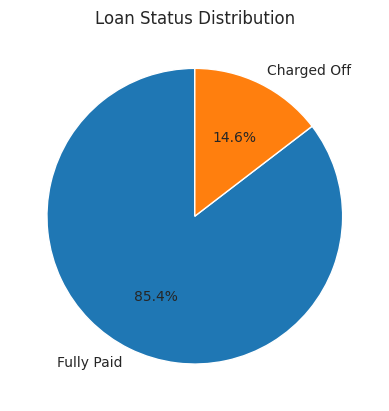

In [31]:
# Gets count of loans grouped by status
loan_status_counts = loan_df['loan_status'].value_counts()


# Get the labels and counts for the pie chart
labels = loan_status_counts.index
counts = loan_status_counts.values

plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)

plt.title('Loan Status Distribution')

plt.show()

<font color=blue>Frequency Distribution of Purpose</font>

### <font color=green> Insights :
Top 3 purposes people are requesting loans for: </font>
<font color=green>
1. Debt Consolidation
2. Credit Card
3. Miscellaneous

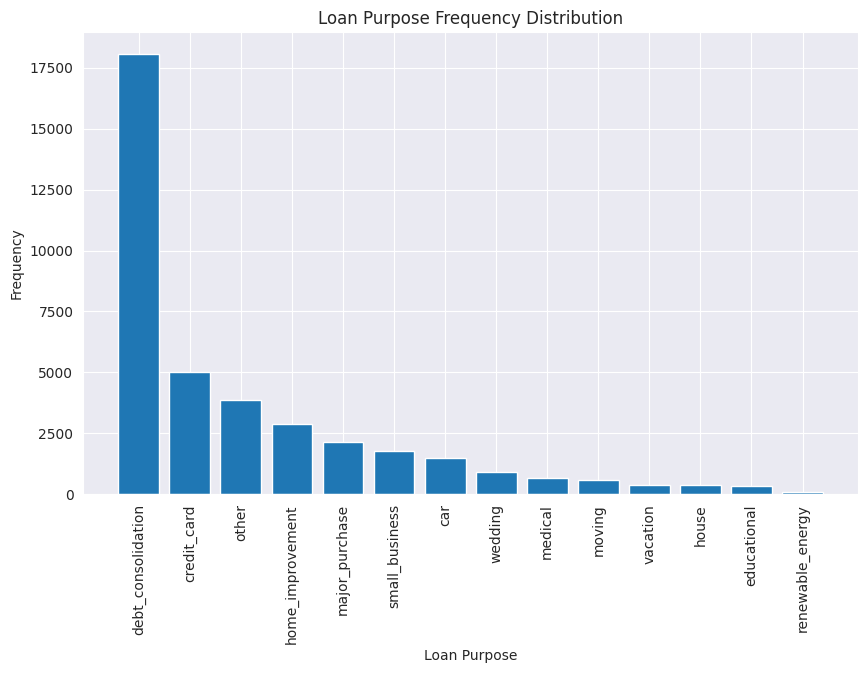

In [32]:
# Calculating frequencies
loan_purpose_counts = loan_df['purpose'].value_counts()


plt.figure(figsize=(10, 6))

plt.bar(loan_purpose_counts.index, loan_purpose_counts.values)

plt.xticks(rotation=90)

plt.title('Loan Purpose Frequency Distribution')
plt.xlabel('Loan Purpose')
plt.ylabel('Frequency')

plt.show()

###<font color=red>__Univariate Analysis across Continuous__</font><br>

<font color=blue>Annual Income Distribution</font>

### <font color=green> Insights :
As we can see below
1. 25 Percent of people earn less than 40,000 per year
2. 50 Percent of people earn less than 60,000 per year
3. 75 Percent of people earn less than 80,000 per year
4. Lowest reported income is 4K while the highest reported income is 60L</font>

Annual Income Quantiles:  [   4000.   40000.   58868.   82000. 6000000.]


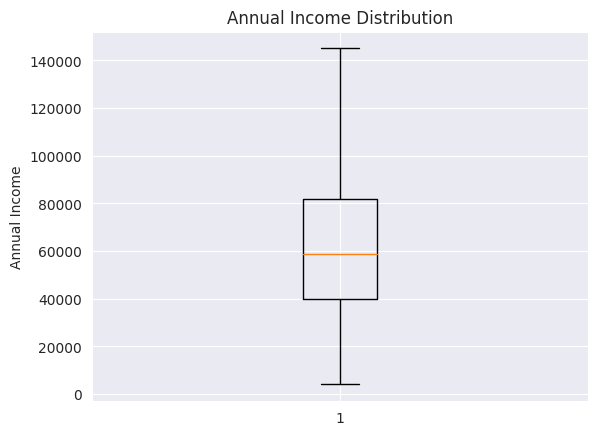

In [33]:
np.set_printoptions(suppress=True)
print("Annual Income Quantiles: ", np.quantile(loan_df['annual_inc'], [0,0.25,0.5,0.75,1]))

# As seen above, quantiles are extreme ranging from 4k to 60L because of outliers.
# Setting showFilers = False to remove outliers.
plt.boxplot(loan_df['annual_inc'], showfliers=False)

plt.ylabel('Annual Income')

plt.title('Annual Income Distribution')

plt.show()

<font color=blue>Loan frequency by Issue Date</font>

### <font color=green> Insights :
As we can see below
1. Most of the loans got funded in the month of Dec
2. Most of the loans got funded in the year of 2011. As years increase, more and more loans are getting funded.  </font>

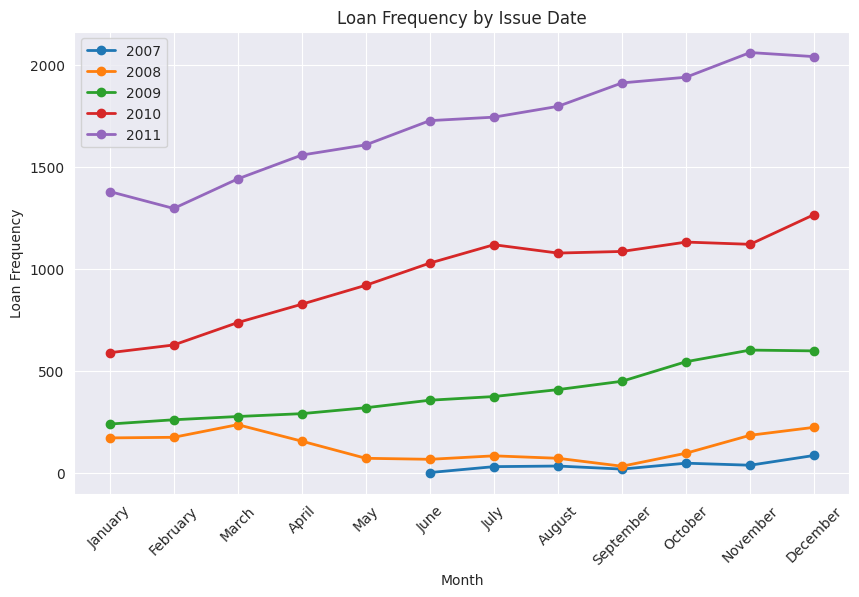

In [34]:
# Convert to date time object and extract month, year
loan_df['issue_d'] = pd.to_datetime(loan_df['issue_d'], format="%b-%y")
loan_df['month'] = loan_df['issue_d'].dt.month
loan_df['year'] = loan_df['issue_d'].dt.year

# Get no of loans month and year wise
issue_freq_counts = loan_df.groupby(['month', 'year']).size().unstack()

plt.figure(figsize=(10, 6))

# From int no, getting month name
month_labels = [calendar.month_name[bin] for bin in issue_freq_counts.index]
# Creating line chart, labelling using years
plt.plot(month_labels, issue_freq_counts.values, marker='o', linestyle='-', linewidth=2, label=issue_freq_counts.columns)

plt.xlabel('Month')
plt.ylabel('Loan Frequency')
plt.title('Loan Frequency by Issue Date')
plt.xticks(rotation=45)

plt.legend()

plt.show()

###<font color=red>__Bivariate Analysis__</font><br>

###<font color=red>__Correlation Analysis__</font><br>

In [35]:
# Getting correlation between numeric variables
loan_corr = loan_df.corr(numeric_only=True)
loan_corr.style.format(precision=2).background_gradient(cmap='RdYlGn')

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,mths_since_last_delinq,month,year
id,1.00,0.99,0.12,0.13,0.23,0.08,0.01,0.09,0.12,0.39,0.85
member_id,0.99,1.00,0.12,0.13,0.24,0.07,0.01,0.09,0.13,0.36,0.88
loan_amnt,0.12,0.12,1.00,0.98,0.94,0.93,0.27,0.06,0.02,0.05,0.11
funded_amnt,0.13,0.13,0.98,1.00,0.96,0.96,0.26,0.06,0.02,0.04,0.12
funded_amnt_inv,0.23,0.24,0.94,0.96,1.00,0.91,0.25,0.07,0.07,0.07,0.25
installment,0.08,0.07,0.93,0.96,0.91,1.00,0.27,0.05,0.00,0.03,0.05
annual_inc,0.01,0.01,0.27,0.26,0.25,0.27,1.00,-0.12,-0.01,0.01,0.01
dti,0.09,0.09,0.06,0.06,0.07,0.05,-0.12,1.00,0.07,0.01,0.09
mths_since_last_delinq,0.12,0.13,0.02,0.02,0.07,0.00,-0.01,0.07,1.00,0.05,0.14
month,0.39,0.36,0.05,0.04,0.07,0.03,0.01,0.01,0.05,1.00,-0.04


In [36]:
# Using one hot encoding with pandas - Trying to get correlation with loan status, a categorical variable
dum_df = pd.get_dummies(loan_df, columns=['loan_status'], prefix=['loan_status'])
dum_df.head(100)

dum_df_corr = dum_df.corr(numeric_only=True)
dum_df_corr.style.format(precision=2).background_gradient(cmap='RdYlGn')

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,mths_since_last_delinq,month,year,loan_status_Charged Off,loan_status_Fully Paid
id,1.00,0.99,0.12,0.13,0.23,0.08,0.01,0.09,0.12,0.39,0.85,0.04,-0.04
member_id,0.99,1.00,0.12,0.13,0.24,0.07,0.01,0.09,0.13,0.36,0.88,0.04,-0.04
loan_amnt,0.12,0.12,1.00,0.98,0.94,0.93,0.27,0.06,0.02,0.05,0.11,0.06,-0.06
funded_amnt,0.13,0.13,0.98,1.00,0.96,0.96,0.26,0.06,0.02,0.04,0.12,0.06,-0.06
funded_amnt_inv,0.23,0.24,0.94,0.96,1.00,0.91,0.25,0.07,0.07,0.07,0.25,0.04,-0.04
installment,0.08,0.07,0.93,0.96,0.91,1.00,0.27,0.05,0.00,0.03,0.05,0.03,-0.03
annual_inc,0.01,0.01,0.27,0.26,0.25,0.27,1.00,-0.12,-0.01,0.01,0.01,-0.04,0.04
dti,0.09,0.09,0.06,0.06,0.07,0.05,-0.12,1.00,0.07,0.01,0.09,0.05,-0.05
mths_since_last_delinq,0.12,0.13,0.02,0.02,0.07,0.00,-0.01,0.07,1.00,0.05,0.14,0.01,-0.01
month,0.39,0.36,0.05,0.04,0.07,0.03,0.01,0.01,0.05,1.00,-0.04,0.02,-0.02


### <font color="red"> __Bivariate Analysis across Categorical__ </font>

<font color=blue>Loan Status Distribution by Term </font>
### <font color=green> Insights :
Lesser term, more likely to default </font>

<Figure size 800x600 with 0 Axes>

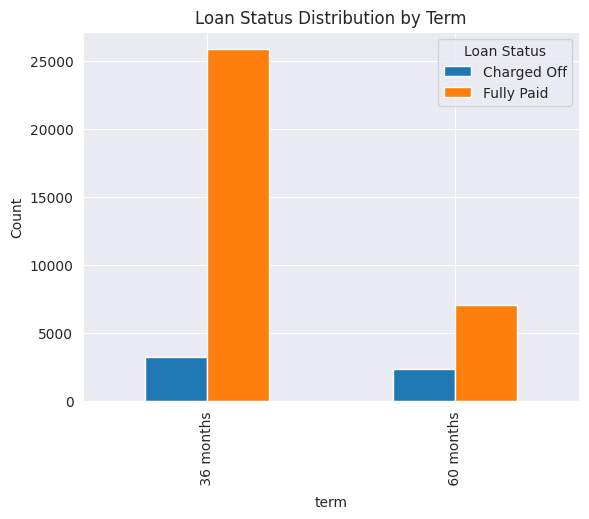

In [37]:
#Using unstack to pivot the innermost level 'loan_status' here and finding counts term and loan status wise
counts = loan_df.groupby(['term', 'loan_status']).size().unstack()
plt.figure(figsize=(8, 6))
counts.plot(kind='bar')
plt.xlabel('term')
plt.ylabel('Count')
plt.title('Loan Status Distribution by Term')
plt.legend(title='Loan Status')
plt.show()

<font color=blue>Loan Status distribution by Verification Status </font>
### <font color=green> Insights :
Doesn't seem like verification status alone has much impact on Loan Defaulting.
As in the plot below, Charged Off loans are less where status is 'Not verified' compared to that of 'Verified' and 'Source Verified'.
One reason for this contradictory behaviour can be, different assessment criteria for borrowers with and without verification. If they have strict requirements for verified borrowers, this could lead to more defaulting. </font>

loan_status          Charged Off  Fully Paid
verification_status                         
Not Verified                2142       14552
Source Verified             1434        8243
Verified                    2051       10155
loan_status          Charged Off  Fully Paid
verification_status                         
Not Verified           12.830957   87.169043
Source Verified        14.818642   85.181358
Verified               16.803212   83.196788


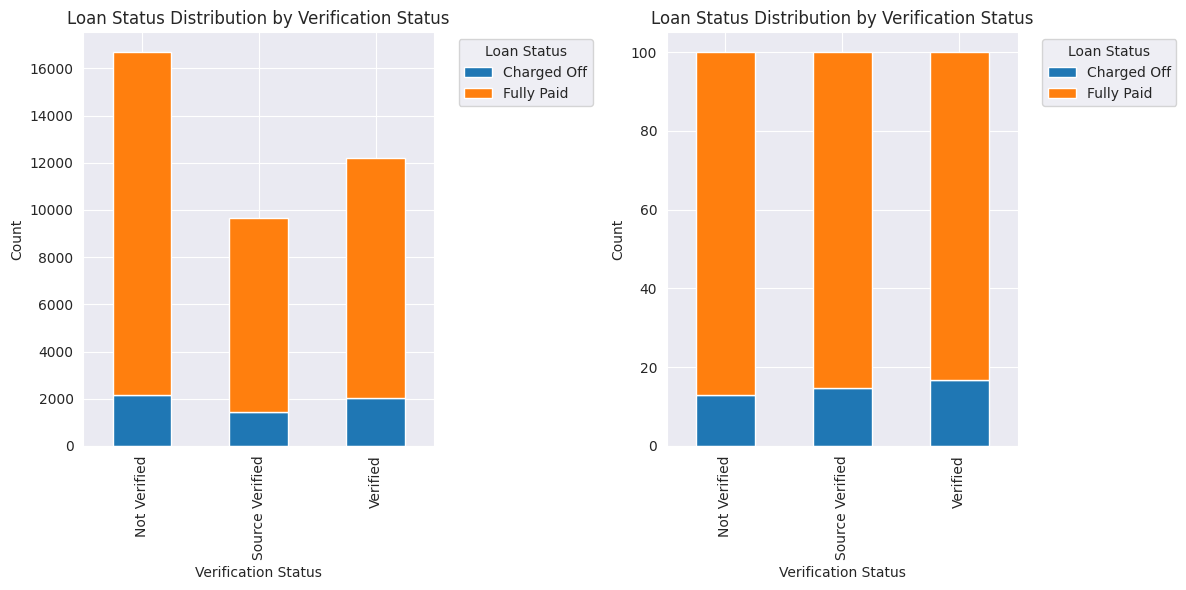

In [38]:
# Creating cross tabulation of Verification and Loan Statuses, categorical variables
crosstab_no_normalize = pd.crosstab(loan_df['verification_status'], loan_df['loan_status'])
print(crosstab_no_normalize)

# If we plot without normalization, the insights are ambiguous
# Hence, we will be using normalize to get clearer insights
crosstab = pd.crosstab(loan_df['verification_status'], loan_df['loan_status'], normalize='index')*100
print(crosstab)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

crosstab_no_normalize.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_xlabel('Verification Status')
ax1.set_ylabel('Count')
ax1.set_title('Loan Status Distribution by Verification Status')
ax1.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')

crosstab.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_xlabel('Verification Status')
ax2.set_ylabel('Count')
ax2.set_title('Loan Status Distribution by Verification Status')
ax2.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

<font color=blue>Loan Status distribution by Employment Length </font>
### <font color=green> Insights :
Not aligning with what we expect i.e, Longer the tenure, lesser the chances of defaulting. Might be because, the dataset here is not correct representative of all the loans.

We see, people with employment length of 1 and 10 years most likely to default  </font>

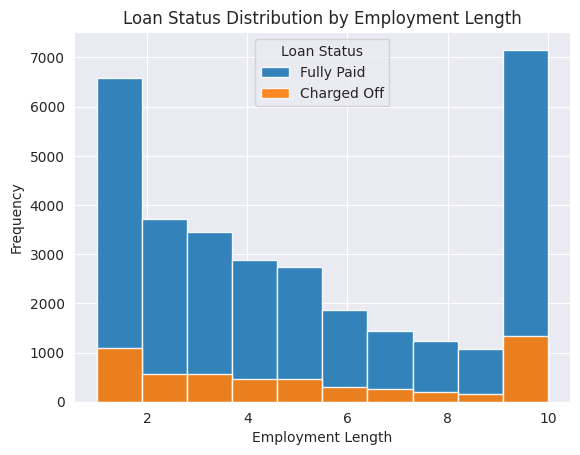

In [46]:
loan_df['emp_length'] = loan_df['emp_length'].str.extract(r'(\d+)')
loan_df['emp_length'] = pd.to_numeric(loan_df['emp_length'])

fully_paid = loan_df[loan_df['loan_status'] == 'Fully Paid']
charged_off = loan_df[loan_df['loan_status'] == 'Charged Off']

# alpha to set transparency, for overlapping areas
plt.hist(fully_paid['emp_length'], bins=10, alpha=0.9, label='Fully Paid')
plt.hist(charged_off['emp_length'], bins=10, alpha=0.9, label='Charged Off')

plt.xlabel('Employment Length')
plt.ylabel('Frequency')
plt.title('Loan Status Distribution by Employment Length')

plt.legend(title='Loan Status')
plt.show()

<font color=blue>Loan Status Distribution by Grade and Sub-Grade </font>
### <font color=green> Insights :
1. Loans graded F and G tend to default more
2. As grade increases from A to G, defaulting risk tends to be higher </font>

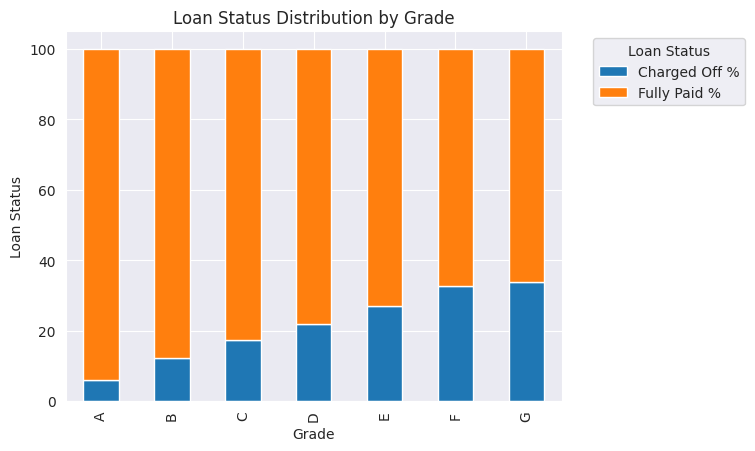

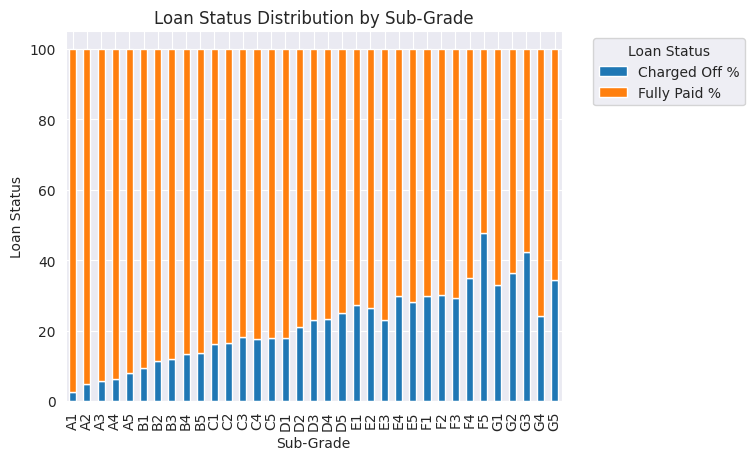

In [40]:
# Using crosstab to create cross-tabulation of grade and loan status
# Normalizes along the rows and we compare distribution of loan status within each grade
cross_tab = pd.crosstab(loan_df['grade'], loan_df['loan_status'], normalize='index')
cross_tab['Charged Off %'] = cross_tab['Charged Off'] * 100
cross_tab['Fully Paid %'] = cross_tab['Fully Paid'] * 100

cross_tab[['Charged Off %', 'Fully Paid %']].plot(kind='bar', stacked=True)
plt.xlabel('Grade')
plt.ylabel('Loan Status')
plt.title('Loan Status Distribution by Grade')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Repeating the same process for subgrades
cross_tab_subgrades = pd.crosstab(loan_df['sub_grade'], loan_df['loan_status'], normalize='index')
cross_tab_subgrades['Charged Off %'] = cross_tab_subgrades['Charged Off'] * 100
cross_tab_subgrades['Fully Paid %'] = cross_tab_subgrades['Fully Paid'] * 100

cross_tab_subgrades[['Charged Off %', 'Fully Paid %']].plot(kind='bar', stacked=True)
plt.xlabel('Sub-Grade')
plt.ylabel('Loan Status')
plt.title('Loan Status Distribution by Sub-Grade')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


<font color=blue>Loan Status Distribution by Purpose </font>
### <font color=green> Insights :
As seen in the chart, top 3 purposes that are most likely to default </font>
<font color=green>
1. small_business
2. renewable_energy
3. educational
</font>

<Figure size 1500x2000 with 0 Axes>

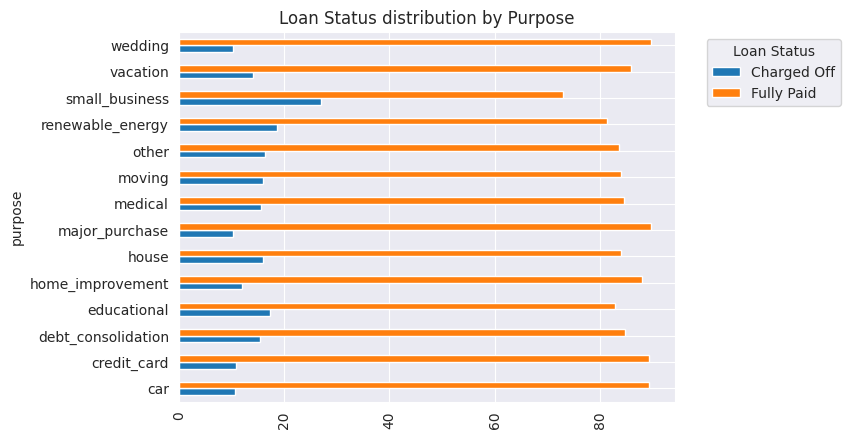

In [41]:
# Cross tab to get relative proportions of loan status within each purpose category
cross_table = pd.crosstab(loan_df['purpose'], loan_df['loan_status'], normalize='index')*100

plt.figure(figsize=(15,20))
cross_table.plot(kind='barh')

plt.xticks(rotation=90)
plt.ylabel('purpose')
plt.title('Loan Status distribution by Purpose')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<font color=blue>Loan Status Distribution by Home Ownership </font>
### <font color=green> Insights :
This is contradictory to what we expect. We expect people with Own House to default less where as those with Mortgages and Rent to default more.
But as observed from the below plot, People with Ownership as "Other" tend to default more followed by "RENT", "OWN" and "MORTGAGE" contradictory to our assumption.  </font>


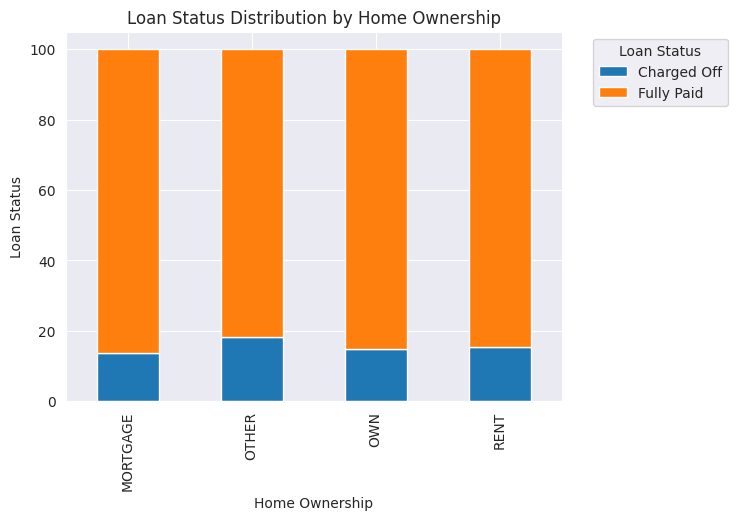

In [50]:
# Ignoring records with HOME OWNERSHIP as NONE, seems like it was not captured and doesnt value add
loan_df = loan_df[loan_df['home_ownership'] != 'NONE']
cross_table = pd.crosstab(loan_df['home_ownership'], loan_df['loan_status'], normalize='index')*100

cross_table[['Charged Off', 'Fully Paid']].plot(kind='bar', stacked=True)
plt.xlabel('Home Ownership')
plt.ylabel('Loan Status')
plt.title('Loan Status Distribution by Home Ownership')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### <font color="red"> __Bivariate Analysis across Continuous__ </font>

<font color=blue>Loan Status Distribution by Annual Income Bins </font>
### <font color=green> Insights :
Lesser annual income, more likely to default. </font>

<font color=blue>As seen in the plot below, quartiles of Charged Off are all lesser than that of Fully Paid.

Indicating loans getting defaulted have annual income lesser compared to that of Fully Paid  </font>

Annual Income Quantiles:  [   4000.   40000.   58868.   82000. 6000000.]


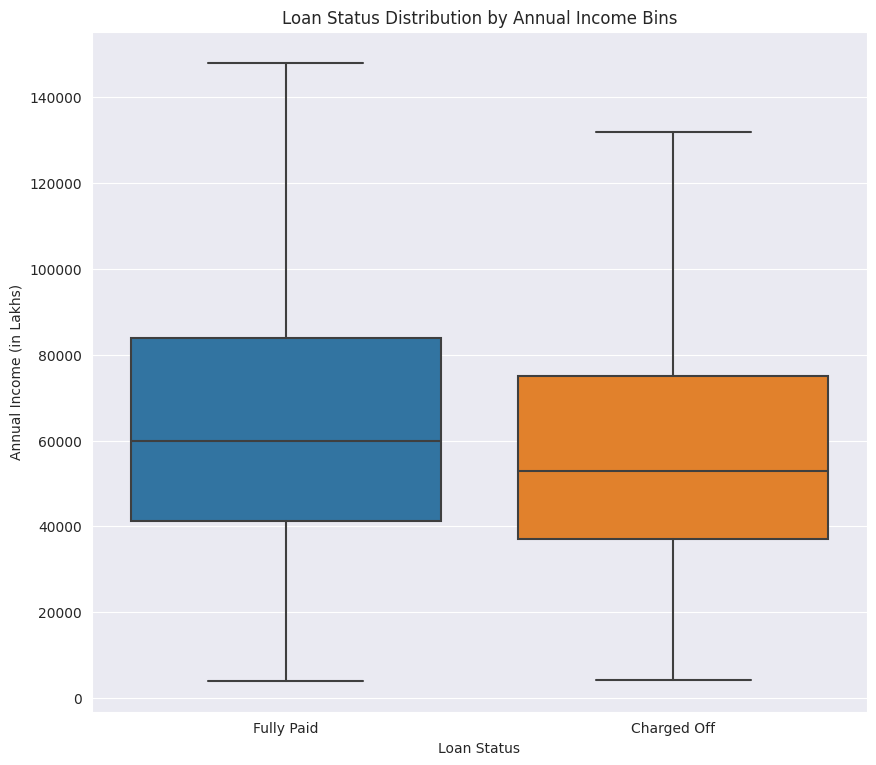

In [42]:
# To turnoff scientific notation
np.set_printoptions(suppress=True)
quantiles = np.quantile(loan_df['annual_inc'], [0,0.25,0.5,0.75,1])
print("Annual Income Quantiles: ",quantiles)

plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=0.2)

# As seen above, quantiles are extreme ranging from 4k to 60L because of outliers.
# Setting showFilers = False to remove outliers.
sns.boxplot(data=loan_df, x='loan_status', y='annual_inc', showfliers = False)

plt.title('Loan Status Distribution by Annual Income Bins')
plt.xlabel('Loan Status')
plt.ylabel('Annual Income (in Lakhs)')

plt.show()

<font color=blue>Loan Status Distribution by Interest Rate Bins </font>
### <font color=green> Insights :
As interest rate increases, loans are most likely to get defaulted </font>

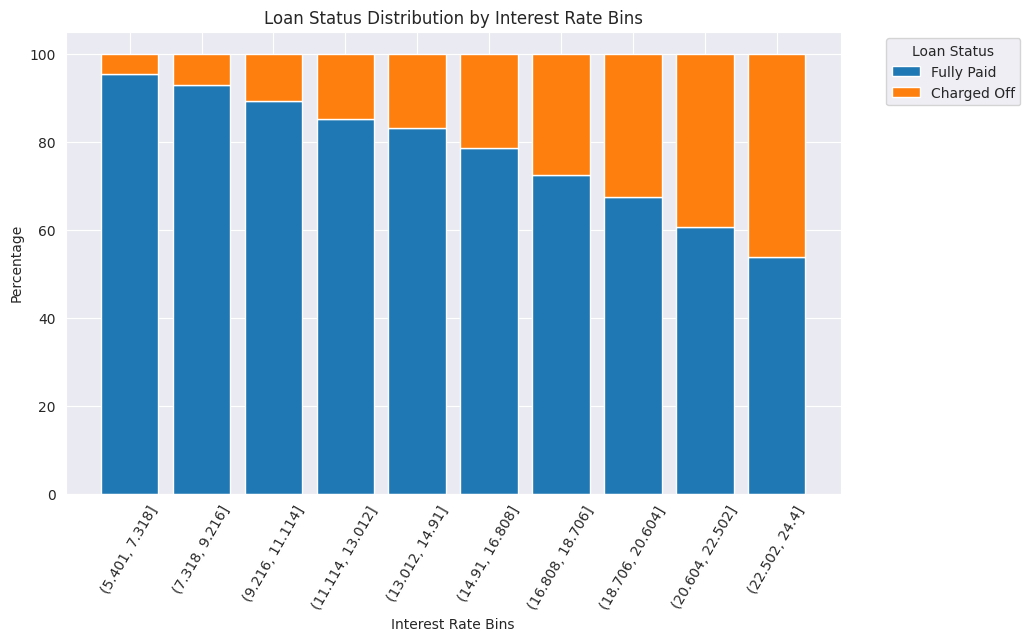

In [43]:
num_bins = 10

# Casting interest rate to float type so that we can do the binning
loan_df['int_rate'] = loan_df['int_rate'].astype(str).str.replace('%','').astype('float64').round(2)

# Using pd.cut to creates equal width bins
loan_df['int_rate_bins'] = pd.cut(loan_df['int_rate'], bins=num_bins)

#Getting counts bin wise, marked sort false as its ordering the bins by count
bin_counts = loan_df['int_rate_bins'].value_counts(sort=False)

#Getting percentages loan status wise grouped by int_rate_bins
#Using normalize=true to get relative percentages. Else raw counts are considered and visualization gives wrong perspective
bin_percentages = loan_df.groupby('int_rate_bins')['loan_status'].value_counts(normalize=True) * 100

fully_paid_percentages = bin_percentages[:, 'Fully Paid']
charged_off_percentages = bin_percentages[:, 'Charged Off']
bin_labels = [str(bin) for bin in bin_counts.index]

plt.figure(figsize=(10, 6))
plt.bar(bin_labels, fully_paid_percentages, label='Fully Paid')
# To create a stacked bar
plt.bar(bin_labels, charged_off_percentages, bottom=fully_paid_percentages, label='Charged Off')
plt.xticks(rotation=60)
plt.title('Loan Status Distribution by Interest Rate Bins')
plt.xlabel('Interest Rate Bins')
plt.ylabel('Percentage')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<font color=blue>Loan Status Distribution by DTI ratio </font>
### <font color=green> Insights :

DTI indicates borrower's ability to manage his/her debt committments. A high DTI means that more of borrower's money already goes towards debt repayment. A low DTI ratio indicates that borrower has more money available.

From the plots below we can see as dti increases, loans are most likely to get defaulted. But this holds only until dti <= 25. Once dti > 25, loans are less likely defaulted. </font>

This might be because as dti reaches 25, it indicates borrower has become thin financially. Lenders might have become more strict in their risk assessment and they might not have been approving loans for people with higher DTIs.</font>

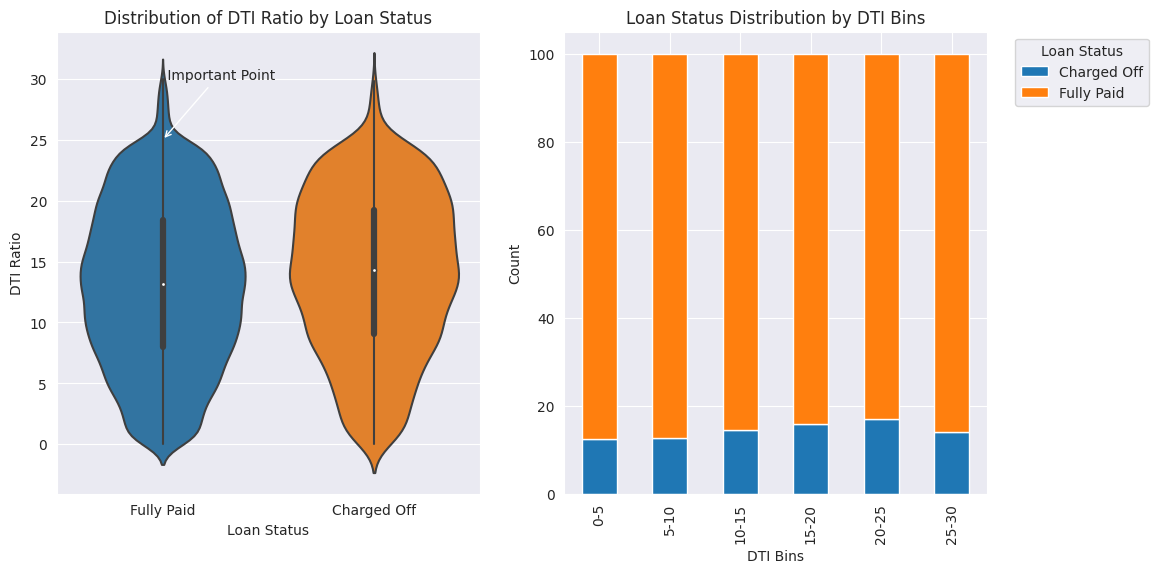

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#Plot 1
sns.violinplot(x=loan_df['loan_status'], y=loan_df['dti'], data=loan_df, ax=ax1)

ax1.set_xlabel('Loan Status')
ax1.set_ylabel('DTI Ratio')
ax1.set_title('Distribution of DTI Ratio by Loan Status')

ax1.annotate(' Important Point', xy=(0, 25), xytext=(0, 30),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

#Plot 2
bins = [0, 5, 10, 15, 20, 25, 30]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30']

# Binning DTI Ratios
loan_df['dti_bin'] = pd.cut(loan_df['dti'], bins=bins, labels=labels, right=False)

# Group loan status by DTI bins
grouped_data = loan_df.groupby(['dti_bin', 'loan_status']).size().unstack()
grouped_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

grouped_data.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_xlabel('DTI Bins')
ax2.set_ylabel('Count')
ax2.set_title('Loan Status Distribution by DTI Bins')
ax2.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()